# MONAI : Tutorial : 2d_segmentation
## UNet training / evaluation

参照URL:
- https://github.com/Project-MONAI/tutorials/tree/main/2d_segmentation/torch

## 0. 準備

In [1]:
# パッケージのインポート
import os
import sys
from glob import glob

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline

from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader, Dataset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    SaveImage,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
)
from monai.visualize import plot_2d_or_3d_image
from monai.utils import set_determinism
from monai.config import print_config

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/pytorch/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.10.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# 乱数シードの設定
set_determinism(seed=2023)

## 1. 学習
### 1.1 学習データ作成

In [3]:
# データフォルダ
temp_dir = os.path.realpath('./data/train_data')
os.makedirs(temp_dir, exist_ok=True)
print(temp_dir)

/home/akira/Medical/MONAI/2d_segmentation/data/train_data


In [4]:
# データ作成
for i in range(40):
    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    Image.fromarray((im * 255).astype('uint8')).save(os.path.join(temp_dir, f'img{i:d}.png'))
    Image.fromarray((seg * 255).astype('uint8')).save(os.path.join(temp_dir, f'seg{i:d}.png'))

In [5]:
# 学習 / 評価 = 20 / 20
images = sorted(glob(os.path.join(temp_dir, 'img*.png')))
segs = sorted(glob(os.path.join(temp_dir, 'seg*.png')))
train_files = [{'img': img, 'seg': seg} for img, seg in zip(images[:20], segs[:20])]
val_files = [{'img': img, 'seg': seg} for img, seg in zip(images[20:], segs[20:])]

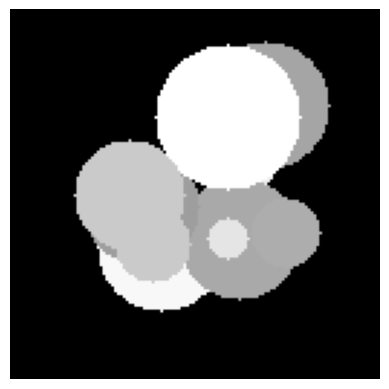

In [6]:
# オリジナル画像
img = Image.open(train_files[0]['img'])
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

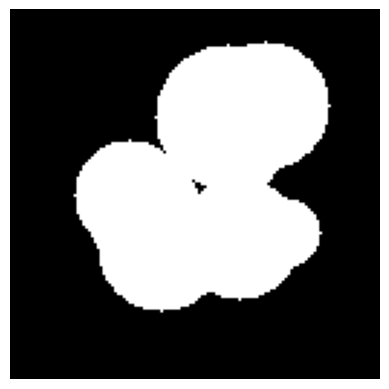

In [7]:
# ラベル画像
seg = Image.open(train_files[0]['seg'])
plt.imshow(seg, cmap='gray')
plt.axis('off')
plt.show()

## 1.2 データセット, データローダ

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=['img', 'seg']),
        EnsureChannelFirstd(keys=['img', 'seg']),
        ScaleIntensityd(keys=['img', 'seg']),
        RandCropByPosNegLabeld(
            keys=['img', 'seg'], label_key='seg', spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        ),
        RandRotate90d(keys=['img', 'seg'], prob=0.5, spatial_axes=[0, 1]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=['img', 'seg']),
        EnsureChannelFirstd(keys=['img', 'seg']),
        ScaleIntensityd(keys=['img', 'seg']),
    ]
)

In [9]:
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds, 
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

## 1.3 モデル構築

In [10]:
dice_metric = DiceMetric(include_background=True, reduction='mean', get_not_nans=False)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# モデル
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [12]:
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 1.4 モデル学習

In [13]:
max_epochs = 10
val_interval = 2

model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

In [14]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

writer = SummaryWriter()
epoch_len = len(train_ds) // train_loader.batch_size

# epochループ
for epoch in range(max_epochs):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # mini batchループ
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['img'].to(device), batch_data['seg'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar('train_loss', loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # 評価
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data['img'].to(device), val_data['seg'].to(device)
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(model_dir, 'best_metric_model_segmentation2d_dict.pth'))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f} "
                f"best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}"
            )
            writer.add_scalar('val_mean_dice', metric, epoch + 1)
            plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag='image')
            plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag='label')
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag='output')
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/10
1/10, train_loss: 0.4667
2/10, train_loss: 0.4649
3/10, train_loss: 0.4635
4/10, train_loss: 0.3857
5/10, train_loss: 0.4448
6/10, train_loss: 0.4456
7/10, train_loss: 0.4318
8/10, train_loss: 0.4043
9/10, train_loss: 0.3914
10/10, train_loss: 0.3982
epoch 1 average loss: 0.4297
----------
epoch 2/10
1/10, train_loss: 0.4012
2/10, train_loss: 0.4190
3/10, train_loss: 0.3824
4/10, train_loss: 0.3931
5/10, train_loss: 0.3838
6/10, train_loss: 0.3806
7/10, train_loss: 0.4061
8/10, train_loss: 0.3970
9/10, train_loss: 0.3806
10/10, train_loss: 0.3947
epoch 2 average loss: 0.3939
saved new best metric model
current epoch: 2 current mean dice: 0.9110 best mean dice: 0.9110 at epoch 2
----------
epoch 3/10
1/10, train_loss: 0.3869
2/10, train_loss: 0.3814
3/10, train_loss: 0.3868
4/10, train_loss: 0.3848
5/10, train_loss: 0.3572
6/10, train_loss: 0.3868
7/10, train_loss: 0.3684
8/10, train_loss: 0.3554
9/10, train_loss: 0.3566
10/10, train_loss: 0.3452
epoch 3 average lo

## 2. 評価
### 2.1 テストデータ作成

In [15]:
# データフォルダ
temp_dir = os.path.realpath('./data/test_data')
os.makedirs(temp_dir, exist_ok=True)
print(temp_dir)

/home/akira/Medical/MONAI/2d_segmentation/data/test_data


In [16]:
# データ作成
for i in range(5):
    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    Image.fromarray((im * 255).astype('uint8')).save(os.path.join(temp_dir, f'img{i:d}.png'))
    Image.fromarray((seg * 255).astype('uint8')).save(os.path.join(temp_dir, f'seg{i:d}.png'))

In [17]:
images = sorted(glob(os.path.join(temp_dir, 'img*.png')))
segs = sorted(glob(os.path.join(temp_dir, 'seg*.png')))
test_files = [{'img': img, 'seg': seg} for img, seg in zip(images, segs)]

## 2.2 データセット, データローダ

In [18]:
test_transforms = Compose(
    [
        LoadImaged(keys=['img', 'seg']),
        EnsureChannelFirstd(keys=['img', 'seg']),
        ScaleIntensityd(keys=['img', 'seg']),
    ]
)

In [19]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

### 2.3 テストデータ評価

In [20]:
saver = SaveImage(output_dir='./output', output_ext='.png', output_postfix='seg')

In [21]:
# モデル読み込み
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_metric_model_segmentation2d_dict.pth')))

<All keys matched successfully>

2023-01-23 13:10:02,916 INFO image_writer.py:194 - writing: output/img0/img0_seg.png


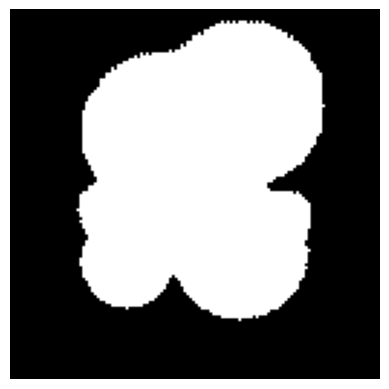

2023-01-23 13:10:03,157 INFO image_writer.py:194 - writing: output/img1/img1_seg.png


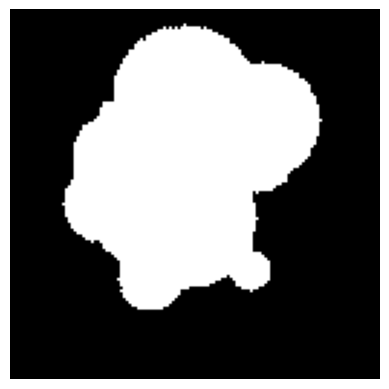

2023-01-23 13:10:03,244 INFO image_writer.py:194 - writing: output/img2/img2_seg.png


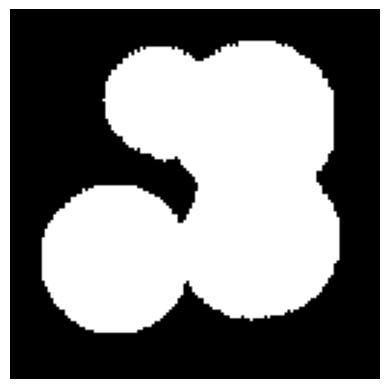

2023-01-23 13:10:03,340 INFO image_writer.py:194 - writing: output/img3/img3_seg.png


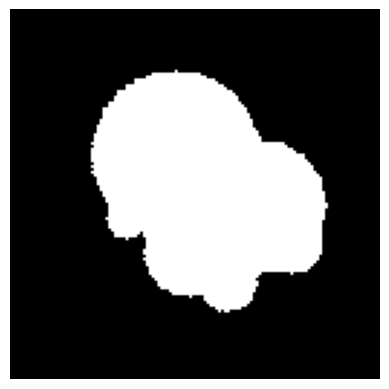

2023-01-23 13:10:03,422 INFO image_writer.py:194 - writing: output/img4/img4_seg.png


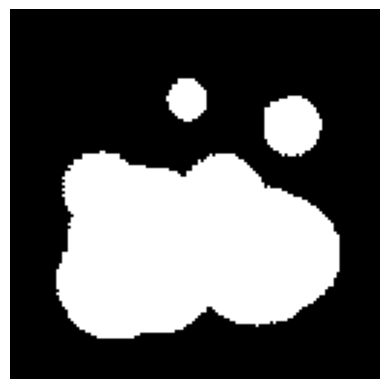

evaluation metric:  0.9939748644828796


In [22]:
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data['img'].to(device), test_data['seg'].to(device)
        # define sliding window and batch size for windows inferense
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        test_labels = decollate_batch(test_labels)
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)
        for test_output in test_outputs:
            saver(test_output)
            img = torch.squeeze(test_output, dim=0).to('cpu')
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()
    # aggregate the final men dice result
    print('evaluation metric: ', dice_metric.aggregate().item())
    # reset the status
    dice_metric.reset()